### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [ ]:
# #
# import sys
# #
# from google.colab import drive
# #
# drive.mount('/content/drive')
# #
# sys.path.append('/content/drive/MyDrive/IntProject')

In [ ]:

import sys

# del sys.modules['data_func']
del sys.modules['utils']
del sys.modules['model']


In [1]:
# pip install yeoda

In [2]:
# pip install tifftools

In [3]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# pip install tqdm

In [5]:
# pip install torchvision


### Data Preparation & Augmentation

In [6]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 1

In [7]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),
    
], )
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),], )


In [8]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                             './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results1.txt'
    model_file = './drive/MyDrive/IntProject/model1.pt'
else:
    train_set = ImageDataset('./train/', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val/', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', test_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results1.txt'
    model_file = './model1.pt'


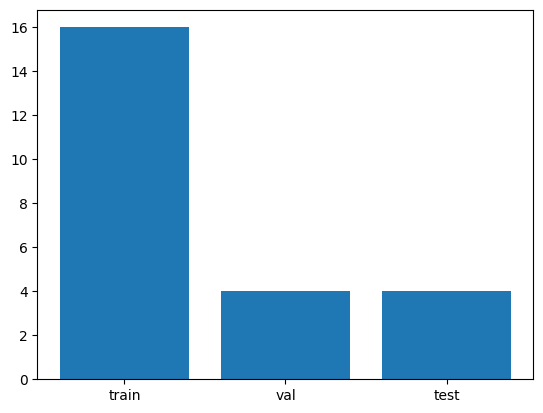

In [12]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

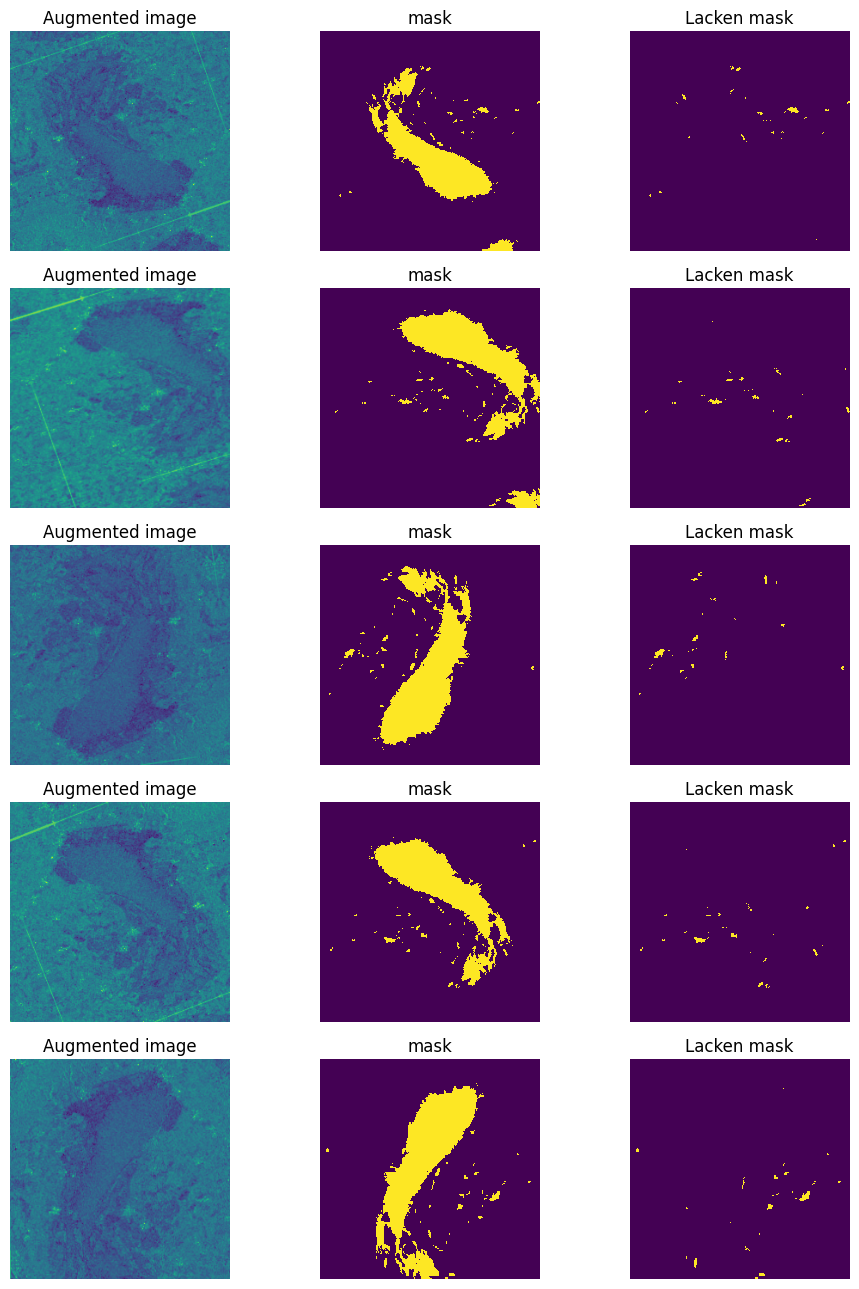

In [13]:
visualize_augmentations(train_set, idx=1, samples=5)


#### Train & Evaluate

In [19]:
epochs = 50
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
global_step = 0

In [20]:
train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, grad_scaler, scheduler, dict_file,
               model_file, best_dice=0, patience=10)

  2%|▏         | 1/50 [00:33<27:45, 33.99s/it]

 
 Epoch: 1 
TRAIN FULL: Train Loss: 1.2779 | Train DICE Coeff: 0.3818  | Train IoU Coeff: 0.2510| | Train Bal Accuracy: 72.47 | Train Accuracy: 76.68 
TRAIN LACKENS: Train DICE Coeff: 0.0118  | Train IoU Coeff: 0.0086|  | Train Bal Accuracy: 58.54 |  Train Accuracy: 73.37 
VAL FULL: Val Loss: 2.0422 | Val DICE Coeff: 0.2329 | Val IoU Coeff: 0.1318 | Val Bal Accuracy: 50.00 | Val Accuracy: 13.19 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.24| 


  4%|▍         | 2/50 [01:07<26:55, 33.67s/it]

 
 Epoch: 2 
TRAIN FULL: Train Loss: 1.0651 | Train DICE Coeff: 0.5468  | Train IoU Coeff: 0.4878| | Train Bal Accuracy: 82.13 | Train Accuracy: 90.25 
TRAIN LACKENS: Train DICE Coeff: 0.0242  | Train IoU Coeff: 0.0139|  | Train Bal Accuracy: 57.58 |  Train Accuracy: 85.36 
VAL FULL: Val Loss: 5.1426 | Val DICE Coeff: 0.2379 | Val IoU Coeff: 0.1351 | Val Bal Accuracy: 50.00 | Val Accuracy: 13.51 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.23| 


  6%|▌         | 3/50 [01:40<26:06, 33.34s/it]

 
 Epoch: 3 
TRAIN FULL: Train Loss: 0.9778 | Train DICE Coeff: 0.5798  | Train IoU Coeff: 0.4880| | Train Bal Accuracy: 83.69 | Train Accuracy: 90.56 
TRAIN LACKENS: Train DICE Coeff: 0.0472  | Train IoU Coeff: 0.0163|  | Train Bal Accuracy: 61.45 |  Train Accuracy: 84.58 
VAL FULL: Val Loss: 6.3253 | Val DICE Coeff: 0.2430 | Val IoU Coeff: 0.1384 | Val Bal Accuracy: 50.00 | Val Accuracy: 13.84 
VAL LACKENS: Val DICE Coeff: 0.0058 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.29| 


  8%|▊         | 4/50 [02:13<25:27, 33.21s/it]

 
 Epoch: 4 
TRAIN FULL: Train Loss: 0.9515 | Train DICE Coeff: 0.6289  | Train IoU Coeff: 0.5663| | Train Bal Accuracy: 82.05 | Train Accuracy: 93.87 
TRAIN LACKENS: Train DICE Coeff: 0.0514  | Train IoU Coeff: 0.0187|  | Train Bal Accuracy: 58.90 |  Train Accuracy: 89.60 
VAL FULL: Val Loss: 7.0772 | Val DICE Coeff: 0.2236 | Val IoU Coeff: 0.1261 | Val Bal Accuracy: 50.01 | Val Accuracy: 12.63 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 50.01 |  Val Accuracy: 0.26| 


 10%|█         | 5/50 [02:47<25:08, 33.53s/it]

 
 Epoch: 5 
TRAIN FULL: Train Loss: 0.9209 | Train DICE Coeff: 0.6086  | Train IoU Coeff: 0.5358| | Train Bal Accuracy: 83.37 | Train Accuracy: 92.21 
TRAIN LACKENS: Train DICE Coeff: 0.0482  | Train IoU Coeff: 0.0162|  | Train Bal Accuracy: 59.67 |  Train Accuracy: 87.00 
VAL FULL: Val Loss: 4.2903 | Val DICE Coeff: 0.2633 | Val IoU Coeff: 0.1481 | Val Bal Accuracy: 55.91 | Val Accuracy: 26.35 
VAL LACKENS: Val DICE Coeff: 0.0057 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 57.71 |  Val Accuracy: 13.79| 


 12%|█▏        | 6/50 [03:21<24:46, 33.78s/it]

 
 Epoch: 6 
TRAIN FULL: Train Loss: 0.8813 | Train DICE Coeff: 0.5669  | Train IoU Coeff: 0.5053| | Train Bal Accuracy: 81.38 | Train Accuracy: 91.62 
TRAIN LACKENS: Train DICE Coeff: 0.0380  | Train IoU Coeff: 0.0159|  | Train Bal Accuracy: 58.10 |  Train Accuracy: 86.99 
VAL FULL: Val Loss: 2.0959 | Val DICE Coeff: 0.3736 | Val IoU Coeff: 0.1778 | Val Bal Accuracy: 53.38 | Val Accuracy: 62.21 
VAL LACKENS: Val DICE Coeff: 0.0032 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 65.02 |  Val Accuracy: 57.76| 


 14%|█▍        | 7/50 [03:55<24:05, 33.63s/it]

 
 Epoch: 7 
TRAIN FULL: Train Loss: 0.8816 | Train DICE Coeff: 0.5783  | Train IoU Coeff: 0.5330| | Train Bal Accuracy: 80.81 | Train Accuracy: 94.01 
TRAIN LACKENS: Train DICE Coeff: 0.0227  | Train IoU Coeff: 0.0165|  | Train Bal Accuracy: 54.72 |  Train Accuracy: 90.79 
VAL FULL: Val Loss: 1.6790 | Val DICE Coeff: 0.4039 | Val IoU Coeff: 0.3309 | Val Bal Accuracy: 47.76 | Val Accuracy: 91.04 
VAL LACKENS: Val DICE Coeff: 0.0048 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 66.57 |  Val Accuracy: 95.28| 


 16%|█▌        | 8/50 [04:27<23:18, 33.30s/it]

 
 Epoch: 8 
TRAIN FULL: Train Loss: 0.8518 | Train DICE Coeff: 0.5773  | Train IoU Coeff: 0.5765| | Train Bal Accuracy: 80.32 | Train Accuracy: 94.24 
TRAIN LACKENS: Train DICE Coeff: 0.0147  | Train IoU Coeff: 0.0165|  | Train Bal Accuracy: 51.89 |  Train Accuracy: 91.12 
VAL FULL: Val Loss: 3.5241 | Val DICE Coeff: 0.0001 | Val IoU Coeff: 0.0000 | Val Bal Accuracy: 50.00 | Val Accuracy: 87.00 
VAL LACKENS: Val DICE Coeff: 0.0091 | Val IoU Coeff: 0.0017 | Val Bal Accuracy: 50.00 |  Val Accuracy: 99.77| 


 18%|█▊        | 9/50 [05:00<22:36, 33.08s/it]

 
 Epoch: 9 
TRAIN FULL: Train Loss: 0.8918 | Train DICE Coeff: 0.5188  | Train IoU Coeff: 0.4666| | Train Bal Accuracy: 74.75 | Train Accuracy: 93.20 
TRAIN LACKENS: Train DICE Coeff: 0.0165  | Train IoU Coeff: 0.0287|  | Train Bal Accuracy: 52.54 |  Train Accuracy: 92.42 
VAL FULL: Val Loss: 1.7627 | Val DICE Coeff: 0.0624 | Val IoU Coeff: 0.0294 | Val Bal Accuracy: 49.81 | Val Accuracy: 88.37 
VAL LACKENS: Val DICE Coeff: 0.0037 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 51.46 |  Val Accuracy: 99.39| 


 20%|██        | 10/50 [05:33<22:08, 33.21s/it]

 
 Epoch: 10 
TRAIN FULL: Train Loss: 0.8704 | Train DICE Coeff: 0.5112  | Train IoU Coeff: 0.4682| | Train Bal Accuracy: 79.75 | Train Accuracy: 91.76 
TRAIN LACKENS: Train DICE Coeff: 0.0212  | Train IoU Coeff: 0.0129|  | Train Bal Accuracy: 57.05 |  Train Accuracy: 88.35 
VAL FULL: Val Loss: 0.8832 | Val DICE Coeff: 0.4676 | Val IoU Coeff: 0.3555 | Val Bal Accuracy: 56.71 | Val Accuracy: 86.02 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0042 | Val Bal Accuracy: 75.63 |  Val Accuracy: 82.99| 


 22%|██▏       | 11/50 [06:06<21:34, 33.19s/it]

 
 Epoch: 11 
TRAIN FULL: Train Loss: 0.8077 | Train DICE Coeff: 0.5589  | Train IoU Coeff: 0.5426| | Train Bal Accuracy: 81.50 | Train Accuracy: 93.11 
TRAIN LACKENS: Train DICE Coeff: 0.0144  | Train IoU Coeff: 0.0123|  | Train Bal Accuracy: 52.90 |  Train Accuracy: 89.07 
VAL FULL: Val Loss: 0.9490 | Val DICE Coeff: 0.3565 | Val IoU Coeff: 0.2204 | Val Bal Accuracy: 48.36 | Val Accuracy: 89.79 
VAL LACKENS: Val DICE Coeff: 0.0005 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 61.13 |  Val Accuracy: 96.48| 


 24%|██▍       | 12/50 [06:39<20:56, 33.05s/it]

 
 Epoch: 12 
TRAIN FULL: Train Loss: 0.7743 | Train DICE Coeff: 0.6147  | Train IoU Coeff: 0.5436| | Train Bal Accuracy: 80.82 | Train Accuracy: 93.91 
TRAIN LACKENS: Train DICE Coeff: 0.0385  | Train IoU Coeff: 0.0133|  | Train Bal Accuracy: 54.21 |  Train Accuracy: 90.26 
VAL FULL: Val Loss: 0.7358 | Val DICE Coeff: 0.6820 | Val IoU Coeff: 0.5504 | Val Bal Accuracy: 48.11 | Val Accuracy: 91.27 
VAL LACKENS: Val DICE Coeff: 0.0041 | Val IoU Coeff: 0.0019 | Val Bal Accuracy: 82.78 |  Val Accuracy: 84.83| 


 26%|██▌       | 13/50 [07:12<20:19, 32.96s/it]

 
 Epoch: 13 
TRAIN FULL: Train Loss: 0.7132 | Train DICE Coeff: 0.6789  | Train IoU Coeff: 0.6246| | Train Bal Accuracy: 84.68 | Train Accuracy: 95.22 
TRAIN LACKENS: Train DICE Coeff: 0.0389  | Train IoU Coeff: 0.0137|  | Train Bal Accuracy: 51.15 |  Train Accuracy: 90.57 
VAL FULL: Val Loss: 0.7511 | Val DICE Coeff: 0.5989 | Val IoU Coeff: 0.4397 | Val Bal Accuracy: 47.58 | Val Accuracy: 92.24 
VAL LACKENS: Val DICE Coeff: 0.0015 | Val IoU Coeff: 0.0007 | Val Bal Accuracy: 72.36 |  Val Accuracy: 93.30| 


 28%|██▊       | 14/50 [07:44<19:42, 32.85s/it]

 
 Epoch: 14 
TRAIN FULL: Train Loss: 0.7264 | Train DICE Coeff: 0.6460  | Train IoU Coeff: 0.5706| | Train Bal Accuracy: 83.21 | Train Accuracy: 94.10 
TRAIN LACKENS: Train DICE Coeff: 0.0482  | Train IoU Coeff: 0.0208|  | Train Bal Accuracy: 58.80 |  Train Accuracy: 89.80 
VAL FULL: Val Loss: 1.1378 | Val DICE Coeff: 0.2505 | Val IoU Coeff: 0.2236 | Val Bal Accuracy: 49.25 | Val Accuracy: 89.79 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0015 | Val Bal Accuracy: 61.40 |  Val Accuracy: 96.15| 


 30%|███       | 15/50 [08:17<19:04, 32.69s/it]

 
 Epoch: 15 
TRAIN FULL: Train Loss: 0.7656 | Train DICE Coeff: 0.6109  | Train IoU Coeff: 0.5290| | Train Bal Accuracy: 82.34 | Train Accuracy: 92.34 
TRAIN LACKENS: Train DICE Coeff: 0.0161  | Train IoU Coeff: 0.0119|  | Train Bal Accuracy: 54.39 |  Train Accuracy: 88.04 
VAL FULL: Val Loss: 0.6559 | Val DICE Coeff: 0.5927 | Val IoU Coeff: 0.4949 | Val Bal Accuracy: 46.99 | Val Accuracy: 93.55 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 74.98 |  Val Accuracy: 93.28| 


 32%|███▏      | 16/50 [08:50<18:33, 32.76s/it]

 
 Epoch: 16 
TRAIN FULL: Train Loss: 0.7213 | Train DICE Coeff: 0.6203  | Train IoU Coeff: 0.5587| | Train Bal Accuracy: 82.72 | Train Accuracy: 93.69 
TRAIN LACKENS: Train DICE Coeff: 0.0479  | Train IoU Coeff: 0.0164|  | Train Bal Accuracy: 55.11 |  Train Accuracy: 89.64 
VAL FULL: Val Loss: 0.7770 | Val DICE Coeff: 0.4923 | Val IoU Coeff: 0.3851 | Val Bal Accuracy: 47.43 | Val Accuracy: 91.65 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 69.29 |  Val Accuracy: 94.46| 


 34%|███▍      | 17/50 [09:23<18:01, 32.77s/it]

 
 Epoch: 17 
TRAIN FULL: Train Loss: 0.7035 | Train DICE Coeff: 0.5841  | Train IoU Coeff: 0.5787| | Train Bal Accuracy: 80.72 | Train Accuracy: 94.65 
TRAIN LACKENS: Train DICE Coeff: 0.0394  | Train IoU Coeff: 0.0180|  | Train Bal Accuracy: 54.26 |  Train Accuracy: 91.41 
VAL FULL: Val Loss: 0.8354 | Val DICE Coeff: 0.3802 | Val IoU Coeff: 0.2439 | Val Bal Accuracy: 48.98 | Val Accuracy: 90.92 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0008 | Val Bal Accuracy: 62.22 |  Val Accuracy: 96.77| 


 36%|███▌      | 18/50 [09:55<17:29, 32.79s/it]

 
 Epoch: 18 
TRAIN FULL: Train Loss: 0.6509 | Train DICE Coeff: 0.6651  | Train IoU Coeff: 0.6080| | Train Bal Accuracy: 83.72 | Train Accuracy: 94.99 
TRAIN LACKENS: Train DICE Coeff: 0.0498  | Train IoU Coeff: 0.0260|  | Train Bal Accuracy: 58.90 |  Train Accuracy: 90.93 
VAL FULL: Val Loss: 0.5925 | Val DICE Coeff: 0.6859 | Val IoU Coeff: 0.5601 | Val Bal Accuracy: 46.45 | Val Accuracy: 92.84 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 78.37 |  Val Accuracy: 90.33| 


 38%|███▊      | 19/50 [10:28<16:55, 32.76s/it]

 
 Epoch: 19 
TRAIN FULL: Train Loss: 0.6349 | Train DICE Coeff: 0.6742  | Train IoU Coeff: 0.6251| | Train Bal Accuracy: 86.22 | Train Accuracy: 94.90 
TRAIN LACKENS: Train DICE Coeff: 0.0514  | Train IoU Coeff: 0.0206|  | Train Bal Accuracy: 54.16 |  Train Accuracy: 88.93 
VAL FULL: Val Loss: 1.1131 | Val DICE Coeff: 0.3581 | Val IoU Coeff: 0.3410 | Val Bal Accuracy: 48.96 | Val Accuracy: 91.17 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0014 | Val Bal Accuracy: 67.55 |  Val Accuracy: 94.56| 


 40%|████      | 20/50 [11:01<16:22, 32.75s/it]

 
 Epoch: 20 
TRAIN FULL: Train Loss: 0.6588 | Train DICE Coeff: 0.6504  | Train IoU Coeff: 0.5680| | Train Bal Accuracy: 84.65 | Train Accuracy: 93.46 
TRAIN LACKENS: Train DICE Coeff: 0.0442  | Train IoU Coeff: 0.0119|  | Train Bal Accuracy: 53.95 |  Train Accuracy: 87.81 
VAL FULL: Val Loss: 0.5245 | Val DICE Coeff: 0.7786 | Val IoU Coeff: 0.6724 | Val Bal Accuracy: 46.43 | Val Accuracy: 95.55 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 85.03 |  Val Accuracy: 89.96| 


 42%|████▏     | 21/50 [11:34<15:49, 32.75s/it]

 
 Epoch: 21 
TRAIN FULL: Train Loss: 0.6731 | Train DICE Coeff: 0.6703  | Train IoU Coeff: 0.5581| | Train Bal Accuracy: 84.11 | Train Accuracy: 92.97 
TRAIN LACKENS: Train DICE Coeff: 0.0290  | Train IoU Coeff: 0.0154|  | Train Bal Accuracy: 56.65 |  Train Accuracy: 87.50 
VAL FULL: Val Loss: 0.5416 | Val DICE Coeff: 0.7590 | Val IoU Coeff: 0.6844 | Val Bal Accuracy: 45.78 | Val Accuracy: 95.44 
VAL LACKENS: Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 85.36 |  Val Accuracy: 89.25| 


 44%|████▍     | 22/50 [12:06<15:18, 32.81s/it]

 
 Epoch: 22 
TRAIN FULL: Train Loss: 0.6194 | Train DICE Coeff: 0.6667  | Train IoU Coeff: 0.6231| | Train Bal Accuracy: 85.77 | Train Accuracy: 94.67 
TRAIN LACKENS: Train DICE Coeff: 0.0390  | Train IoU Coeff: 0.0141|  | Train Bal Accuracy: 54.69 |  Train Accuracy: 89.29 
VAL FULL: Val Loss: 0.9192 | Val DICE Coeff: 0.3148 | Val IoU Coeff: 0.2147 | Val Bal Accuracy: 49.30 | Val Accuracy: 90.35 
VAL LACKENS: Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 60.78 |  Val Accuracy: 97.02| 


 46%|████▌     | 23/50 [12:39<14:45, 32.81s/it]

 
 Epoch: 23 
TRAIN FULL: Train Loss: 0.5717 | Train DICE Coeff: 0.7101  | Train IoU Coeff: 0.6598| | Train Bal Accuracy: 86.97 | Train Accuracy: 95.65 
TRAIN LACKENS: Train DICE Coeff: 0.0527  | Train IoU Coeff: 0.0185|  | Train Bal Accuracy: 58.42 |  Train Accuracy: 89.84 
VAL FULL: Val Loss: 1.5729 | Val DICE Coeff: 0.1096 | Val IoU Coeff: 0.0680 | Val Bal Accuracy: 50.58 | Val Accuracy: 87.26 
VAL LACKENS: Val DICE Coeff: 0.0095 | Val IoU Coeff: 0.0047 | Val Bal Accuracy: 53.36 |  Val Accuracy: 98.71| 


 48%|████▊     | 24/50 [13:12<14:14, 32.85s/it]

 
 Epoch: 24 
TRAIN FULL: Train Loss: 0.5681 | Train DICE Coeff: 0.6997  | Train IoU Coeff: 0.6197| | Train Bal Accuracy: 86.23 | Train Accuracy: 95.13 
TRAIN LACKENS: Train DICE Coeff: 0.0425  | Train IoU Coeff: 0.0214|  | Train Bal Accuracy: 60.70 |  Train Accuracy: 89.97 
VAL FULL: Val Loss: 1.0562 | Val DICE Coeff: 0.3972 | Val IoU Coeff: 0.2232 | Val Bal Accuracy: 55.00 | Val Accuracy: 80.21 
VAL LACKENS: Val DICE Coeff: 0.0043 | Val IoU Coeff: 0.0036 | Val Bal Accuracy: 64.11 |  Val Accuracy: 82.25| 


 50%|█████     | 25/50 [13:45<13:43, 32.93s/it]

 
 Epoch: 25 
TRAIN FULL: Train Loss: 0.5786 | Train DICE Coeff: 0.6889  | Train IoU Coeff: 0.6204| | Train Bal Accuracy: 85.49 | Train Accuracy: 94.92 
TRAIN LACKENS: Train DICE Coeff: 0.0567  | Train IoU Coeff: 0.0208|  | Train Bal Accuracy: 58.78 |  Train Accuracy: 89.59 
VAL FULL: Val Loss: 1.4091 | Val DICE Coeff: 0.1795 | Val IoU Coeff: 0.1473 | Val Bal Accuracy: 47.55 | Val Accuracy: 65.20 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0021 | Val Bal Accuracy: 57.02 |  Val Accuracy: 66.17| 


 52%|█████▏    | 26/50 [14:19<13:13, 33.06s/it]

 
 Epoch: 26 
TRAIN FULL: Train Loss: 0.5562 | Train DICE Coeff: 0.7009  | Train IoU Coeff: 0.6390| | Train Bal Accuracy: 85.84 | Train Accuracy: 95.34 
TRAIN LACKENS: Train DICE Coeff: 0.0538  | Train IoU Coeff: 0.0220|  | Train Bal Accuracy: 53.99 |  Train Accuracy: 90.32 
VAL FULL: Val Loss: 0.6786 | Val DICE Coeff: 0.6023 | Val IoU Coeff: 0.5036 | Val Bal Accuracy: 48.85 | Val Accuracy: 94.14 
VAL LACKENS: Val DICE Coeff: 0.0024 | Val IoU Coeff: 0.0015 | Val Bal Accuracy: 76.08 |  Val Accuracy: 93.31| 


 54%|█████▍    | 27/50 [14:52<12:38, 32.98s/it]

 
 Epoch: 27 
TRAIN FULL: Train Loss: 0.5537 | Train DICE Coeff: 0.6826  | Train IoU Coeff: 0.6292| | Train Bal Accuracy: 85.85 | Train Accuracy: 95.13 
TRAIN LACKENS: Train DICE Coeff: 0.0550  | Train IoU Coeff: 0.0178|  | Train Bal Accuracy: 57.73 |  Train Accuracy: 89.59 
VAL FULL: Val Loss: 1.2111 | Val DICE Coeff: 0.3281 | Val IoU Coeff: 0.2301 | Val Bal Accuracy: 49.73 | Val Accuracy: 89.41 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0021 | Val Bal Accuracy: 61.85 |  Val Accuracy: 95.56| 


 56%|█████▌    | 28/50 [15:25<12:06, 33.01s/it]

 
 Epoch: 28 
TRAIN FULL: Train Loss: 0.5376 | Train DICE Coeff: 0.7110  | Train IoU Coeff: 0.6261| | Train Bal Accuracy: 87.26 | Train Accuracy: 94.64 
TRAIN LACKENS: Train DICE Coeff: 0.0432  | Train IoU Coeff: 0.0193|  | Train Bal Accuracy: 56.66 |  Train Accuracy: 88.32 
VAL FULL: Val Loss: 0.7804 | Val DICE Coeff: 0.5384 | Val IoU Coeff: 0.4330 | Val Bal Accuracy: 59.03 | Val Accuracy: 88.75 
VAL LACKENS: Val DICE Coeff: 0.0061 | Val IoU Coeff: 0.0046 | Val Bal Accuracy: 80.09 |  Val Accuracy: 84.03| 


 58%|█████▊    | 29/50 [16:01<11:54, 34.01s/it]

 
 Epoch: 29 
TRAIN FULL: Train Loss: 0.5403 | Train DICE Coeff: 0.6911  | Train IoU Coeff: 0.6252| | Train Bal Accuracy: 87.35 | Train Accuracy: 94.44 
TRAIN LACKENS: Train DICE Coeff: 0.0220  | Train IoU Coeff: 0.0118|  | Train Bal Accuracy: 53.99 |  Train Accuracy: 87.88 
VAL FULL: Val Loss: 0.9238 | Val DICE Coeff: 0.4818 | Val IoU Coeff: 0.3226 | Val Bal Accuracy: 58.61 | Val Accuracy: 82.68 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0041 | Val Bal Accuracy: 78.87 |  Val Accuracy: 77.29| 


 60%|██████    | 30/50 [16:36<11:27, 34.35s/it]

 
 Epoch: 30 
TRAIN FULL: Train Loss: 0.5038 | Train DICE Coeff: 0.7247  | Train IoU Coeff: 0.6497| | Train Bal Accuracy: 87.75 | Train Accuracy: 95.16 
TRAIN LACKENS: Train DICE Coeff: 0.0568  | Train IoU Coeff: 0.0218|  | Train Bal Accuracy: 58.52 |  Train Accuracy: 88.86 
VAL FULL: Val Loss: 1.2640 | Val DICE Coeff: 0.5203 | Val IoU Coeff: 0.2550 | Val Bal Accuracy: 52.68 | Val Accuracy: 65.06 
VAL LACKENS: Val DICE Coeff: 0.0058 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 78.91 |  Val Accuracy: 53.44| 


 62%|██████▏   | 31/50 [17:11<10:53, 34.38s/it]

 
 Epoch: 31 
TRAIN FULL: Train Loss: 0.5443 | Train DICE Coeff: 0.7017  | Train IoU Coeff: 0.6358| | Train Bal Accuracy: 85.97 | Train Accuracy: 95.11 
TRAIN LACKENS: Train DICE Coeff: 0.0372  | Train IoU Coeff: 0.0183|  | Train Bal Accuracy: 57.59 |  Train Accuracy: 89.39 
VAL FULL: Val Loss: 0.6180 | Val DICE Coeff: 0.6785 | Val IoU Coeff: 0.5531 | Val Bal Accuracy: 51.33 | Val Accuracy: 91.72 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 83.58 |  Val Accuracy: 85.24| 


 64%|██████▍   | 32/50 [17:45<10:17, 34.29s/it]

 
 Epoch: 32 
TRAIN FULL: Train Loss: 0.5337 | Train DICE Coeff: 0.7046  | Train IoU Coeff: 0.6407| | Train Bal Accuracy: 86.05 | Train Accuracy: 94.91 
TRAIN LACKENS: Train DICE Coeff: 0.0522  | Train IoU Coeff: 0.0246|  | Train Bal Accuracy: 53.35 |  Train Accuracy: 89.12 
VAL FULL: Val Loss: 0.6188 | Val DICE Coeff: 0.6329 | Val IoU Coeff: 0.5323 | Val Bal Accuracy: 46.45 | Val Accuracy: 93.87 
VAL LACKENS: Val DICE Coeff: 0.0004 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 76.77 |  Val Accuracy: 92.69| 


 66%|██████▌   | 33/50 [18:20<09:46, 34.47s/it]

 
 Epoch: 33 
TRAIN FULL: Train Loss: 0.5118 | Train DICE Coeff: 0.7121  | Train IoU Coeff: 0.6420| | Train Bal Accuracy: 85.75 | Train Accuracy: 95.13 
TRAIN LACKENS: Train DICE Coeff: 0.0515  | Train IoU Coeff: 0.0285|  | Train Bal Accuracy: 61.52 |  Train Accuracy: 89.42 
VAL FULL: Val Loss: 0.4325 | Val DICE Coeff: 0.7651 | Val IoU Coeff: 0.6989 | Val Bal Accuracy: 45.83 | Val Accuracy: 95.61 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0006 | Val Bal Accuracy: 86.14 |  Val Accuracy: 88.95| 


 68%|██████▊   | 34/50 [18:54<09:12, 34.54s/it]

 
 Epoch: 34 
TRAIN FULL: Train Loss: 0.5298 | Train DICE Coeff: 0.6930  | Train IoU Coeff: 0.6334| | Train Bal Accuracy: 87.28 | Train Accuracy: 94.87 
TRAIN LACKENS: Train DICE Coeff: 0.0606  | Train IoU Coeff: 0.0258|  | Train Bal Accuracy: 60.28 |  Train Accuracy: 88.60 
VAL FULL: Val Loss: 1.0097 | Val DICE Coeff: 0.5394 | Val IoU Coeff: 0.3120 | Val Bal Accuracy: 53.76 | Val Accuracy: 72.37 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 82.72 |  Val Accuracy: 60.25| 


 70%|███████   | 35/50 [19:28<08:35, 34.37s/it]

 
 Epoch: 35 
TRAIN FULL: Train Loss: 0.5066 | Train DICE Coeff: 0.7037  | Train IoU Coeff: 0.6460| | Train Bal Accuracy: 86.31 | Train Accuracy: 95.25 
TRAIN LACKENS: Train DICE Coeff: 0.0394  | Train IoU Coeff: 0.0206|  | Train Bal Accuracy: 53.49 |  Train Accuracy: 89.09 
VAL FULL: Val Loss: 0.9078 | Val DICE Coeff: 0.3854 | Val IoU Coeff: 0.2919 | Val Bal Accuracy: 48.75 | Val Accuracy: 89.67 
VAL LACKENS: Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 64.77 |  Val Accuracy: 95.14| 


 72%|███████▏  | 36/50 [20:01<07:54, 33.88s/it]

 
 Epoch: 36 
TRAIN FULL: Train Loss: 0.4932 | Train DICE Coeff: 0.7062  | Train IoU Coeff: 0.6475| | Train Bal Accuracy: 87.61 | Train Accuracy: 95.28 
TRAIN LACKENS: Train DICE Coeff: 0.0424  | Train IoU Coeff: 0.0216|  | Train Bal Accuracy: 61.46 |  Train Accuracy: 88.55 
VAL FULL: Val Loss: 0.9953 | Val DICE Coeff: 0.2606 | Val IoU Coeff: 0.1973 | Val Bal Accuracy: 48.69 | Val Accuracy: 89.50 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0001 | Val Bal Accuracy: 59.87 |  Val Accuracy: 97.18| 


 74%|███████▍  | 37/50 [20:34<07:16, 33.61s/it]

 
 Epoch: 37 
TRAIN FULL: Train Loss: 0.5229 | Train DICE Coeff: 0.6972  | Train IoU Coeff: 0.6285| | Train Bal Accuracy: 85.59 | Train Accuracy: 95.05 
TRAIN LACKENS: Train DICE Coeff: 0.0553  | Train IoU Coeff: 0.0236|  | Train Bal Accuracy: 60.74 |  Train Accuracy: 89.55 
VAL FULL: Val Loss: 0.6021 | Val DICE Coeff: 0.6910 | Val IoU Coeff: 0.5578 | Val Bal Accuracy: 46.02 | Val Accuracy: 93.26 
VAL LACKENS: Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0005 | Val Bal Accuracy: 79.75 |  Val Accuracy: 89.94| 


 76%|███████▌  | 38/50 [21:07<06:40, 33.35s/it]

 
 Epoch: 38 
TRAIN FULL: Train Loss: 0.6229 | Train DICE Coeff: 0.6657  | Train IoU Coeff: 0.5735| | Train Bal Accuracy: 83.44 | Train Accuracy: 93.18 
TRAIN LACKENS: Train DICE Coeff: 0.0471  | Train IoU Coeff: 0.0175|  | Train Bal Accuracy: 54.40 |  Train Accuracy: 88.25 
VAL FULL: Val Loss: 0.9127 | Val DICE Coeff: 0.3838 | Val IoU Coeff: 0.3074 | Val Bal Accuracy: 48.55 | Val Accuracy: 91.03 
VAL LACKENS: Val DICE Coeff: 0.0019 | Val IoU Coeff: 0.0007 | Val Bal Accuracy: 65.40 |  Val Accuracy: 95.74| 


 78%|███████▊  | 39/50 [21:40<06:05, 33.21s/it]

 
 Epoch: 39 
TRAIN FULL: Train Loss: 0.4934 | Train DICE Coeff: 0.7197  | Train IoU Coeff: 0.6460| | Train Bal Accuracy: 86.21 | Train Accuracy: 95.25 
TRAIN LACKENS: Train DICE Coeff: 0.0511  | Train IoU Coeff: 0.0329|  | Train Bal Accuracy: 61.31 |  Train Accuracy: 89.66 
VAL FULL: Val Loss: 0.6117 | Val DICE Coeff: 0.6161 | Val IoU Coeff: 0.5310 | Val Bal Accuracy: 46.77 | Val Accuracy: 94.28 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002 | Val Bal Accuracy: 77.01 |  Val Accuracy: 93.00| 


 80%|████████  | 40/50 [22:13<05:31, 33.18s/it]

 
 Epoch: 40 
TRAIN FULL: Train Loss: 0.5850 | Train DICE Coeff: 0.6577  | Train IoU Coeff: 0.5824| | Train Bal Accuracy: 83.39 | Train Accuracy: 93.35 
TRAIN LACKENS: Train DICE Coeff: 0.0534  | Train IoU Coeff: 0.0262|  | Train Bal Accuracy: 61.16 |  Train Accuracy: 87.95 
VAL FULL: Val Loss: 0.9202 | Val DICE Coeff: 0.3676 | Val IoU Coeff: 0.2758 | Val Bal Accuracy: 48.91 | Val Accuracy: 89.74 
VAL LACKENS: Val DICE Coeff: 0.0022 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 63.81 |  Val Accuracy: 95.81| 


 82%|████████▏ | 41/50 [22:46<04:58, 33.15s/it]

 
 Epoch: 41 
TRAIN FULL: Train Loss: 0.5140 | Train DICE Coeff: 0.7004  | Train IoU Coeff: 0.6352| | Train Bal Accuracy: 85.53 | Train Accuracy: 95.20 
TRAIN LACKENS: Train DICE Coeff: 0.0550  | Train IoU Coeff: 0.0212|  | Train Bal Accuracy: 58.36 |  Train Accuracy: 89.62 
VAL FULL: Val Loss: 1.4569 | Val DICE Coeff: 0.2457 | Val IoU Coeff: 0.1547 | Val Bal Accuracy: 49.62 | Val Accuracy: 88.33 
VAL LACKENS: Val DICE Coeff: 0.0068 | Val IoU Coeff: 0.0017 | Val Bal Accuracy: 57.73 |  Val Accuracy: 97.26| 


 84%|████████▍ | 42/50 [23:19<04:24, 33.08s/it]

 
 Epoch: 42 
TRAIN FULL: Train Loss: 0.5132 | Train DICE Coeff: 0.7048  | Train IoU Coeff: 0.6241| | Train Bal Accuracy: 85.35 | Train Accuracy: 94.76 
TRAIN LACKENS: Train DICE Coeff: 0.0536  | Train IoU Coeff: 0.0188|  | Train Bal Accuracy: 57.93 |  Train Accuracy: 88.90 
VAL FULL: Val Loss: 1.1023 | Val DICE Coeff: 0.4188 | Val IoU Coeff: 0.2893 | Val Bal Accuracy: 55.52 | Val Accuracy: 85.37 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0045 | Val Bal Accuracy: 68.35 |  Val Accuracy: 86.50| 


 86%|████████▌ | 43/50 [23:52<03:51, 33.04s/it]

 
 Epoch: 43 
TRAIN FULL: Train Loss: 0.4944 | Train DICE Coeff: 0.6875  | Train IoU Coeff: 0.6389| | Train Bal Accuracy: 85.49 | Train Accuracy: 95.35 
TRAIN LACKENS: Train DICE Coeff: 0.0540  | Train IoU Coeff: 0.0218|  | Train Bal Accuracy: 61.36 |  Train Accuracy: 89.77 
VAL FULL: Val Loss: 0.6394 | Val DICE Coeff: 0.6128 | Val IoU Coeff: 0.4847 | Val Bal Accuracy: 49.51 | Val Accuracy: 93.29 
VAL LACKENS: Val DICE Coeff: 0.0032 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 74.56 |  Val Accuracy: 93.23| 


 88%|████████▊ | 44/50 [24:25<03:18, 33.03s/it]

 
 Epoch: 44 
TRAIN FULL: Train Loss: 0.5073 | Train DICE Coeff: 0.7084  | Train IoU Coeff: 0.6333| | Train Bal Accuracy: 88.52 | Train Accuracy: 94.76 
TRAIN LACKENS: Train DICE Coeff: 0.0484  | Train IoU Coeff: 0.0209|  | Train Bal Accuracy: 54.98 |  Train Accuracy: 88.60 
VAL FULL: Val Loss: 1.2880 | Val DICE Coeff: 0.1024 | Val IoU Coeff: 0.0633 | Val Bal Accuracy: 50.48 | Val Accuracy: 88.07 
VAL LACKENS: Val DICE Coeff: 0.0075 | Val IoU Coeff: 0.0045 | Val Bal Accuracy: 53.15 |  Val Accuracy: 98.91| 


 90%|█████████ | 45/50 [24:58<02:45, 33.07s/it]

 
 Epoch: 45 
TRAIN FULL: Train Loss: 0.4715 | Train DICE Coeff: 0.7234  | Train IoU Coeff: 0.6433| | Train Bal Accuracy: 87.56 | Train Accuracy: 94.71 
TRAIN LACKENS: Train DICE Coeff: 0.0369  | Train IoU Coeff: 0.0159|  | Train Bal Accuracy: 57.59 |  Train Accuracy: 88.23 
VAL FULL: Val Loss: 1.2847 | Val DICE Coeff: 0.1902 | Val IoU Coeff: 0.1540 | Val Bal Accuracy: 49.38 | Val Accuracy: 88.66 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0011 | Val Bal Accuracy: 57.70 |  Val Accuracy: 97.63| 


 92%|█████████▏| 46/50 [25:32<02:13, 33.31s/it]

 
 Epoch: 46 
TRAIN FULL: Train Loss: 0.5070 | Train DICE Coeff: 0.6926  | Train IoU Coeff: 0.6176| | Train Bal Accuracy: 87.29 | Train Accuracy: 94.67 
TRAIN LACKENS: Train DICE Coeff: 0.0431  | Train IoU Coeff: 0.0201|  | Train Bal Accuracy: 58.05 |  Train Accuracy: 88.78 
VAL FULL: Val Loss: 0.5148 | Val DICE Coeff: 0.7082 | Val IoU Coeff: 0.6222 | Val Bal Accuracy: 46.62 | Val Accuracy: 95.21 
VAL LACKENS: Val DICE Coeff: 0.0009 | Val IoU Coeff: 0.0004 | Val Bal Accuracy: 81.41 |  Val Accuracy: 91.72| 


 94%|█████████▍| 47/50 [26:05<01:40, 33.39s/it]

 
 Epoch: 47 
TRAIN FULL: Train Loss: 0.4434 | Train DICE Coeff: 0.7410  | Train IoU Coeff: 0.6752| | Train Bal Accuracy: 88.54 | Train Accuracy: 95.56 
TRAIN LACKENS: Train DICE Coeff: 0.0443  | Train IoU Coeff: 0.0239|  | Train Bal Accuracy: 61.30 |  Train Accuracy: 88.90 
VAL FULL: Val Loss: 0.9086 | Val DICE Coeff: 0.4651 | Val IoU Coeff: 0.3984 | Val Bal Accuracy: 50.97 | Val Accuracy: 91.49 
VAL LACKENS: Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0031 | Val Bal Accuracy: 71.16 |  Val Accuracy: 92.90| 


 96%|█████████▌| 48/50 [26:38<01:06, 33.27s/it]

 
 Epoch: 48 
TRAIN FULL: Train Loss: 0.5430 | Train DICE Coeff: 0.6973  | Train IoU Coeff: 0.5989| | Train Bal Accuracy: 84.86 | Train Accuracy: 93.87 
TRAIN LACKENS: Train DICE Coeff: 0.0405  | Train IoU Coeff: 0.0194|  | Train Bal Accuracy: 58.74 |  Train Accuracy: 87.91 
VAL FULL: Val Loss: 0.5447 | Val DICE Coeff: 0.7476 | Val IoU Coeff: 0.6275 | Val Bal Accuracy: 51.54 | Val Accuracy: 94.31 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 87.71 |  Val Accuracy: 87.12| 


 98%|█████████▊| 49/50 [27:11<00:33, 33.22s/it]

 
 Epoch: 49 
TRAIN FULL: Train Loss: 0.4849 | Train DICE Coeff: 0.7328  | Train IoU Coeff: 0.6556| | Train Bal Accuracy: 87.53 | Train Accuracy: 95.40 
TRAIN LACKENS: Train DICE Coeff: 0.0574  | Train IoU Coeff: 0.0183|  | Train Bal Accuracy: 60.15 |  Train Accuracy: 88.92 
VAL FULL: Val Loss: 1.4098 | Val DICE Coeff: 0.4629 | Val IoU Coeff: 0.2608 | Val Bal Accuracy: 57.81 | Val Accuracy: 73.24 
VAL LACKENS: Val DICE Coeff: 0.0043 | Val IoU Coeff: 0.0033 | Val Bal Accuracy: 73.06 |  Val Accuracy: 67.31| 


100%|██████████| 50/50 [27:45<00:00, 33.31s/it]

 
 Epoch: 50 
TRAIN FULL: Train Loss: 0.5263 | Train DICE Coeff: 0.6918  | Train IoU Coeff: 0.6186| | Train Bal Accuracy: 85.96 | Train Accuracy: 94.36 
TRAIN LACKENS: Train DICE Coeff: 0.0584  | Train IoU Coeff: 0.0234|  | Train Bal Accuracy: 59.69 |  Train Accuracy: 88.03 
VAL FULL: Val Loss: 1.2508 | Val DICE Coeff: 0.4638 | Val IoU Coeff: 0.2966 | Val Bal Accuracy: 59.57 | Val Accuracy: 77.60 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0042 | Val Bal Accuracy: 76.11 |  Val Accuracy: 71.44| 


#### Evaluating on Test Data

In [9]:
model = UNet(1,1)
state_dict = torch.load(model_file)  # Load the state_dict
model.load_state_dict(state_dict)  # Load weights into the model
model = model.to(device)

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_5602/2905527223.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_file)  # Load th

Dice Coefficient: 0.8629118800163269
Dice Coefficient Lackens: 0.0013301088474690914


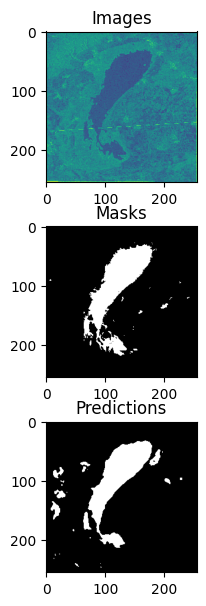

Dice Coefficient: 0.6880038380622864
Dice Coefficient Lackens: 0.012011577375233173


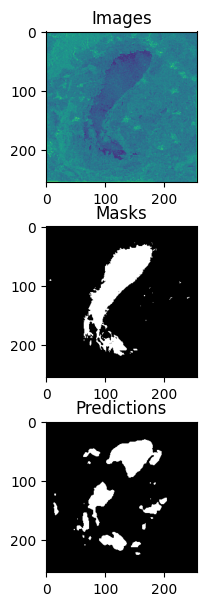

Dice Coefficient: 0.8843281269073486
Dice Coefficient Lackens: 0.0011958543909713626


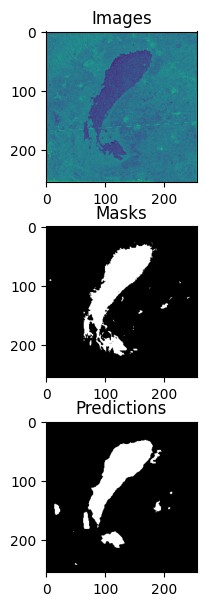

Dice Coefficient: 0.8380507826805115
Dice Coefficient Lackens: 0.005732913501560688


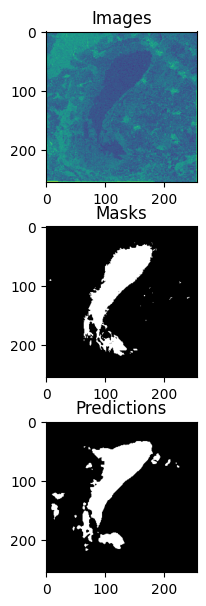

In [10]:
def display_batch(images, masks, pred,lacken_masks):
    print(f"Dice Coefficient: {dice_coeff(pred.to(device), masks.to(device))}")
    print(f"Dice Coefficient Lackens: {dice_coeff(pred.to(device), lacken_masks.to(device))}")

    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    pred = pred.cpu().numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap='gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predictions')

    plt.show()


for images, masks, lacken_masks in testloader:
    with torch.no_grad():

        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()


    display_batch(images, masks, pred,lacken_masks)
